# Replicates version 0.4  
return to BRCA

## Experimental notes

In [123]:
from IPython.display import Image

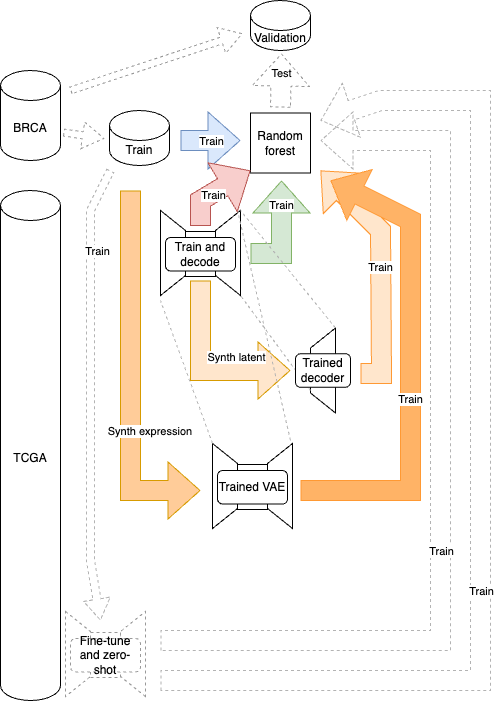

In [126]:
Image(filename='val_five.png', width = 400)

## Imports

In [127]:
v = 'rep_0.4' # iteration directory name, within ignored i_o
v

'rep_0.4'

In [171]:
%whos

Variable                      Type                      Data/Info
-----------------------------------------------------------------
Activation                    type                      <class 'keras.layers.core.activation.Activation'>
BatchNormalization            type                      <class 'keras.layers.norm<...>tion.BatchNormalization'>
Callback                      type                      <class 'keras.callbacks.Callback'>
CustomVariationalLayer        type                      <class '__main__.CustomVariationalLayer'>
Image                         type                      <class 'IPython.core.display.Image'>
K                             TFModuleWrapper           <module 'tensorflow.compa<...>ras/backend/__init__.py'>
Layer                         type                      <class 'keras.engine.base_layer.Layer'>
Model                         type                      <class 'keras.engine.training.Model'>
RF_output                     list                      n=10
Rando

In [3]:
import seaborn as sns
import pandas as pd
import glob as glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
from statistics import stdev
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Layer
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from matplotlib import rcParams 
from random import sample
from sklearn.metrics import accuracy_score
from statannot import add_stat_annotation

## VAE Setup

In [4]:
# Function set for leave one out loop
def compute_latent(x): # x: This function is argument one in the Lambda layer
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim), mean=0., stddev=1.0 )
    return mu + K.exp(sigma/2)*eps

# Set custom layer , will need all this at start of shell script
class CustomVariationalLayer(Layer):
    """
    Define a custom layer
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

## Data

In [5]:
file_paths_no_LGGGGBM = sorted(
    glob.glob(
        'i_o/GEXP_MAD_5k_across_no_LGGGBM/*.tsv' # <---- LGGGBM excluded
    ))

In [9]:
file_paths_no_LGGGGBM[8]

'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv'

In [5]:
file_paths = sorted(
    glob.glob(
        'i_o/GEXP_MAD_5k_across/*.tsv' # <---- LGGGBM included
    ))

In [129]:
len(file_paths)

26

In [7]:
file_paths[8]

'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv'

In [6]:
file_paths

['i_o/GEXP_MAD_5k_across/ACC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BLCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BRCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/CESC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/COADREAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/ESCC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/GEA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/HNSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRP_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LGGGBM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LIHCCHOL_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/MESO_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/OV_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PAAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PCPG_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PRAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SARC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SKCM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across

In [9]:
len_list = []
for path in file_paths:
    file = pd.read_csv(path, sep = '\t', index_col = 0)
    len_list.append((file.index.name, len(file)))

In [10]:
len_list # KIRCKICH is third largest with 556 samples
        # HNSC has 506 for fourth
        # LUAD has an even 500 samples as the fifth most samples

[('ACC', 76),
 ('BLCA', 399),
 ('BRCA', 995),
 ('CESC', 177),
 ('COADREAD', 449),
 ('ESCC', 86),
 ('GEA', 461),
 ('HNSC', 506),
 ('KIRCKICH', 556),
 ('KIRP', 155),
 ('LGGGBM', 782),
 ('LIHCCHOL', 378),
 ('LUAD', 500),
 ('LUSC', 460),
 ('MESO', 74),
 ('OV', 285),
 ('PAAD', 76),
 ('PCPG', 159),
 ('PRAD', 273),
 ('SARC', 191),
 ('SKCM', 444),
 ('TGCT', 133),
 ('THCA', 486),
 ('THYM', 117),
 ('UCEC', 499),
 ('UVM', 74)]

### Pre-train

In [130]:
file_paths

['i_o/GEXP_MAD_5k_across/ACC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BLCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BRCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/CESC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/COADREAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/ESCC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/GEA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/HNSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRP_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LGGGBM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LIHCCHOL_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/MESO_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/OV_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PAAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PCPG_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PRAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SARC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SKCM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across

In [131]:
TCGA_no_BRCA = ['i_o/GEXP_MAD_5k_across/ACC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/BLCA_across_5k.tsv',
 # 'i_o/GEXP_MAD_5k_across/BRCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/CESC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/COADREAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/ESCC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/GEA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/HNSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/KIRP_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LGGGBM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LIHCCHOL_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/MESO_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/OV_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PAAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PCPG_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/PRAD_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SARC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/SKCM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/TGCT_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/THCA_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/THYM_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/UCEC_across_5k.tsv',
 'i_o/GEXP_MAD_5k_across/UVM_across_5k.tsv']

### No LGGGBM

In [14]:
TCGA_no_BRCA = ['i_o/GEXP_MAD_5k_across_no_LGGGBM/ACC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BLCA_across_5k_no_LGGGBM.tsv',
 # 'i_o/GEXP_MAD_5k_across_no_LGGGBM/BRCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/CESC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/COADREAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/ESCC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/GEA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/HNSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRCKICH_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/KIRP_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LIHCCHOL_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/LUSC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/MESO_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/OV_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PAAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PCPG_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/PRAD_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/SARC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/SKCM_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/TGCT_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/THCA_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/THYM_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/UCEC_across_5k_no_LGGGBM.tsv',
 'i_o/GEXP_MAD_5k_across_no_LGGGBM/UVM_across_5k_no_LGGGBM.tsv']

In [ ]:
### Build an all-but-one TCGA dataframe

In [132]:
tall_stack = pd.DataFrame()
for path in TCGA_no_BRCA:
    print(path)
    file = pd.read_csv(
    path, sep = '\t', index_col = 0)
    tall_stack = pd.concat( [tall_stack, file] ,
                           axis = 0)

i_o/GEXP_MAD_5k_across/ACC_across_5k.tsv
i_o/GEXP_MAD_5k_across/BLCA_across_5k.tsv
i_o/GEXP_MAD_5k_across/CESC_across_5k.tsv
i_o/GEXP_MAD_5k_across/COADREAD_across_5k.tsv
i_o/GEXP_MAD_5k_across/ESCC_across_5k.tsv
i_o/GEXP_MAD_5k_across/GEA_across_5k.tsv
i_o/GEXP_MAD_5k_across/HNSC_across_5k.tsv
i_o/GEXP_MAD_5k_across/KIRCKICH_across_5k.tsv
i_o/GEXP_MAD_5k_across/KIRP_across_5k.tsv
i_o/GEXP_MAD_5k_across/LGGGBM_across_5k.tsv
i_o/GEXP_MAD_5k_across/LIHCCHOL_across_5k.tsv
i_o/GEXP_MAD_5k_across/LUAD_across_5k.tsv
i_o/GEXP_MAD_5k_across/LUSC_across_5k.tsv
i_o/GEXP_MAD_5k_across/MESO_across_5k.tsv
i_o/GEXP_MAD_5k_across/OV_across_5k.tsv
i_o/GEXP_MAD_5k_across/PAAD_across_5k.tsv
i_o/GEXP_MAD_5k_across/PCPG_across_5k.tsv
i_o/GEXP_MAD_5k_across/PRAD_across_5k.tsv
i_o/GEXP_MAD_5k_across/SARC_across_5k.tsv
i_o/GEXP_MAD_5k_across/SKCM_across_5k.tsv
i_o/GEXP_MAD_5k_across/TGCT_across_5k.tsv
i_o/GEXP_MAD_5k_across/THCA_across_5k.tsv
i_o/GEXP_MAD_5k_across/THYM_across_5k.tsv
i_o/GEXP_MAD_5k_across/U

In [133]:
tall_stack.shape # hold-out all of BRCA

(7796, 5001)

In [113]:
tall_stack.shape # hold-out BRCA, LGGGBM dropped

(7014, 5001)

In [114]:
tall_stack.head(1)

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
TCGA-OR-A5J1,ACC_2,0.000182,0.360981,0.001892,0.007364,0.0,0.0,0.0,0.000284,0.00609,...,0.246175,0.542221,0.402793,0.335923,0.241655,0.232638,0.13753,0.278195,0.306376,0.078349


In [134]:
pre_train_file = tall_stack

In [135]:
pre_train_file.shape

(7796, 5001)

### Direct / fine-tune

In [136]:
fine_tune_file = pd.read_csv(
    file_paths[2], # BRCA from replicates 0.2
    sep = '\t', index_col = 0)
fine_tune_file.index.name

'BRCA'

In [10]:
fine_tune_file = pd.read_csv(
    file_paths_no_LGGGGBM[8], # KIRCKICH
    sep = '\t', index_col = 0)

In [ ]:
fine_tune_file = pd.read_csv(
    file_paths[10], # KIRCKICH
    sep = '\t', index_col = 0)

In [137]:
fine_tune_file

,Labels,N:GEXP::COL1A1:1277:,N:GEXP::TG:7038:,N:GEXP::FN1:2335:,N:GEXP::SERPINA1:5265:,N:GEXP::COL3A1:1281:,N:GEXP::COL1A2:1278:,N:GEXP::FTL:2512:,N:GEXP::GAPDH:2597:,N:GEXP::ACTB:60:,...,N:GEXP::DECR2:26063:,N:GEXP::ATPAF1:64756:,N:GEXP::TSPAN17:26262:,N:GEXP::TMEM50B:757:,N:GEXP::TMEM125:128218:,N:GEXP::NMD3:51068:,N:GEXP::HS2ST1:9653:,N:GEXP::CDH13:1012:,N:GEXP::C8orf30A:51236:,N:GEXP::SLC41A3:54946:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,BRCA_1,0.031385,0.009340,0.039359,0.046129,0.031442,0.018842,0.087729,0.089627,0.136415,...,0.134333,0.395323,0.211688,0.285639,0.233318,0.203803,0.242757,0.060273,0.172109,0.526240
TCGA-3C-AALI,BRCA_4,0.101237,0.030875,0.091098,0.028947,0.071486,0.053656,0.109263,0.248707,0.348832,...,0.221111,0.184540,0.200623,0.120528,0.247122,0.183697,0.128036,0.145553,0.177389,0.498367
TCGA-3C-AALJ,BRCA_2,0.102118,0.026908,0.102970,0.002073,0.069342,0.051479,0.181907,0.182647,0.358672,...,0.393196,0.162478,0.192225,0.105651,0.137341,0.162629,0.120194,0.104077,0.302681,0.230708
TCGA-3C-AALK,BRCA_1,0.245417,0.028296,0.116361,0.008146,0.195194,0.128708,0.090467,0.143409,0.321840,...,0.189172,0.163491,0.190177,0.158288,0.220929,0.145901,0.163564,0.111635,0.127003,0.270418
TCGA-4H-AAAK,BRCA_1,0.233795,0.015375,0.208902,0.004443,0.238647,0.162215,0.104993,0.140335,0.308237,...,0.115154,0.174519,0.152611,0.175450,0.228238,0.179946,0.223932,0.121891,0.173570,0.322601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44,BRCA_1,0.151985,0.008408,0.066331,0.001252,0.068486,0.067384,0.182326,0.130463,0.735460,...,0.549026,0.175498,0.160633,0.205027,0.163870,0.125576,0.083509,0.038011,0.147255,0.183957
TCGA-XX-A899,BRCA_1,0.115542,0.007113,0.087292,0.008191,0.131443,0.066699,0.097668,0.119608,0.313509,...,0.138364,0.151470,0.200950,0.204139,0.189732,0.175460,0.194509,0.100316,0.101179,0.274839
TCGA-XX-A89A,BRCA_1,0.254498,0.004876,0.150192,0.012612,0.259711,0.130643,0.217217,0.086321,0.361050,...,0.152896,0.155937,0.187217,0.139626,0.669949,0.182596,0.212924,0.099072,0.134256,0.239085


In [138]:
fine_tune_file.Labels.value_counts()

BRCA_1    535
BRCA_2    205
BRCA_3    175
BRCA_4     80
Name: Labels, dtype: int64

In [11]:
fine_tune_file.index.name

'BRCA'

### MSigDB setup

In [55]:
with open('i_o/MSigDB/c2.all.v2022.1.Hs.symbols.gmt.txt') as gmt:
    print(gmt.read(3000))

SHARMA_ASTROCYTOMA_WITH_NF1_SYNDROM	http://www.gsea-msigdb.org/gsea/msigdb/human/geneset/SHARMA_ASTROCYTOMA_WITH_NF1_SYNDROM	ADGRV1	MAP3K7CL	CLEC3B	SLC1A3	STN1
LIU_OVARIAN_CANCER_TUMORS_AND_XENOGRAFTS_XDGS_UP	http://www.gsea-msigdb.org/gsea/msigdb/human/geneset/LIU_OVARIAN_CANCER_TUMORS_AND_XENOGRAFTS_XDGS_UP	RPLP0P11	PFN1P11	DSCAM-AS1	MT-TS2	FGB	MT-TL2	PAX2	FOXB1	MAGEC2	SLC28A2	LINC02593	CPLX2	MGAT5B	SBK2	LEMD1-DT	ANK1	EVPLL	TGM7	LCN10	ENSG00000262884	DISP3	SIAH3	IGSF23	RD3	MYOM3	MIR4664	NAT8L	ALPL	LINC01001	FOXI3	KCNH3	GRIN2B	XKR7	CELSR3	CICP27	RASSF10	LINC02108	SKIDA1	STAG3L3	FAR2P1	LINC01224	ID1	WDR62	CCDC150	PLEKHG4B	RBM25-AS1	STAG3L5P	KIF18B	ZDHHC8P1	DDX12P	MKRN3	GOLGA2P5	TUBA5P	ZNF114	LINC00319	MYBL2	UCA1	KSR2	CYSRT1	MIR1302-9HG	HASPIN	MKI67	CNGB1	MIR29B2CHG	GGT2P	CCNF	SNORD86	LY6G5B	FBN3	DUX4L27	RNFT2	ULBP3	MAP3K9	LINC01873	LINC01764	LINC00958	TROAP	PALM3	PIF1	OCLNP1	P2RY2	GPAT4-AS1	RAP1GAP2	ENSG00000260874	KIF12	PAX8-AS1	FAM215B	MT-TH	PROX2	CLSPN	LHX4	SULT1A3	DACT2	GPC1-AS1	LI

In [57]:
!pip3 install gsea_api

  Preparing metadata (setup.py) ... done
  Created wheel for gsea_api: filename=gsea_api-0.3.4-py3-none-any.whl size=16222 sha256=30b329bf5aefd824a4c97e0302b9a1d8a68920c5ef139cb7c2a9a82a3e3fede1
  Stored in directory: /Users/karlberb/Library/Caches/pip/wheels/56/15/35/fba801a64dbbeffa992988de38bcc17e110862d467a07136e1
Successfully built gsea_api


In [58]:
from gsea_api.molecular_signatures_db import GeneSets

In [72]:
!pip3 install gseapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.1/444.1 kB 7.8 MB/s eta 0:00:0000:01


In [73]:
import gseapy as gp

In [75]:
hlmrk = gp.read_gmt(path="i_o/MSigDB/c2.all.v2022.1.Hs.symbols.gmt")

In [ ]:
hlmrk.keys()

In [77]:
len(hlmrk)

6449

In [ ]:
pd.DataFrame(hlmrk)

## Validation split

### Inpt devel

In [16]:
len (fine_tune_file) / 2

497.5

In [17]:
len (fine_tune_file)

995

In [139]:
len (fine_tune_file) * .25 # 25%

248.75

In [147]:
trn_size = 249 # want to take down to ~50 samples
trn_size

249

In [140]:
inpt_val = pd.DataFrame() # blue
lat_val = pd.DataFrame() # Turning this back on, red
dec_val = pd.DataFrame() # green
synth_lat_val = pd.DataFrame() # dark orange
synth_inpt_val = pd.DataFrame() # light orange

In [141]:
%whos DataFrame

Variable                      Type         Data/Info
----------------------------------------------------
X_trn                         DataFrame        N:GEXP::COL1A1:1277: <...>[497 rows x 5000 columns]
X_val                         DataFrame                  N:GEXP::COL<...>[498 rows x 5000 columns]
accuracy_curve_frame          DataFrame        data_phase  step_size<...>n\n[150 rows x 3 columns]
box_curve_frame               DataFrame        data_phase  step_size<...>n\n[600 rows x 3 columns]
dec_val                       DataFrame    Empty DataFrame\nColumns: []\nIndex: []
decoded                       DataFrame                  N:GEXP::COL<...>[497 rows x 5000 columns]
decoded_bx_crv                DataFrame       data_phase  step_size <...>n\n[150 rows x 3 columns]
decoded_labeled               DataFrame                  Labels  N:G<...>[497 rows x 5001 columns]
df_to_clf                     DataFrame        Labels  N:GEXP::COL1A<...>[497 rows x 5001 columns]
file               

In [142]:
repeats = 10 # to all random forest validation runs

In [ ]:
# Start Replicate run here, toggle the validation split code

In [261]:
val_split = 'vs03' # Replicates TOGGGLE <---
trn = fine_tune_file.sample(trn_size) # Build train and validation files from fine-tune
val = fine_tune_file.loc[fine_tune_file[~fine_tune_file.index.isin(trn.index)].index, :]

In [262]:
val_split

'vs03'

In [263]:
trn.shape

(249, 5001)

In [264]:
val.shape

(746, 5001)

## Input validation plot

In [265]:
pretrain_status = '_TCGA_5_epochs'

In [266]:
print('Start input validation with RF')
val_inpt_acrcy_lst = []
val_inpt_running_average = []

X_trn = trn.iloc[:, 1:]
y_trn = trn.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('Half way to 10 rpts')    
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_inpt_acrcy_lst.append(val_raw_acc) # Box plots
    val_inpt_running_average.append(mean(val_inpt_acrcy_lst))
inpt_val.insert(0, val_split, val_inpt_running_average)
print('Input transfer predictions complete')

Start input validation with RF
Half way to 10 rpts
Input transfer predictions complete


In [267]:
inpt_val

,vs03,vs02,vs01,vs00
0,0.797587,0.824397,0.856568,0.852547
1,0.801609,0.823727,0.851206,0.845174
2,0.800715,0.823503,0.850313,0.845398
3,0.801609,0.826408,0.853217,0.848190
4,0.802681,0.826005,0.852547,0.845845
5,0.802279,0.826631,0.855228,0.844504
6,0.802183,0.826120,0.853696,0.841823
7,0.801273,0.825402,0.852547,0.842326
8,0.802353,0.825290,0.852398,0.841674
9,0.803485,0.826273,0.851743,0.842091


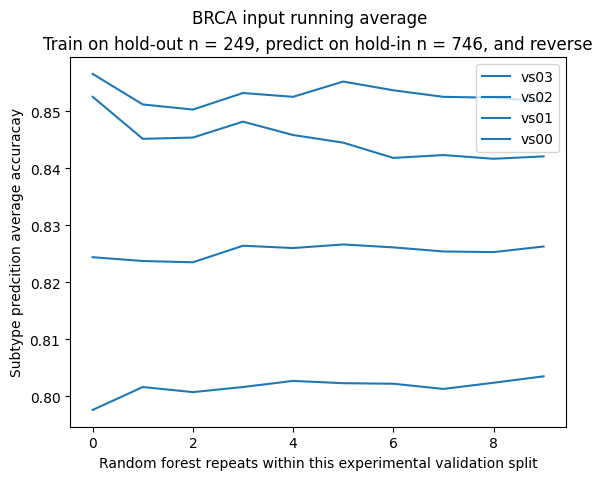

In [268]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
plt.suptitle(fine_tune_file.index.name + ' input running average')
plt.title('Train on hold-out n = '+str(
    len(trn))+', predict on hold-in n = '+str(
    len(val))+', and reverse')
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+str(fine_tune_file.index.name)+'input_running_average_repeats_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')

### Box setup

In [77]:
inpt_val.iloc[9, :] # final row is most-updated average

vs03    0.882424
vs04    0.857778
vs05    0.881010
Name: 9, dtype: float64

In [48]:
len(inpt_val.iloc[9, :])

2

In [101]:
inpt_val.iloc[9, :]

vs05    0.902424
vs04    0.898586
vs03    0.872525
vs02    0.890707
vs01    0.883232
Name: 9, dtype: float64

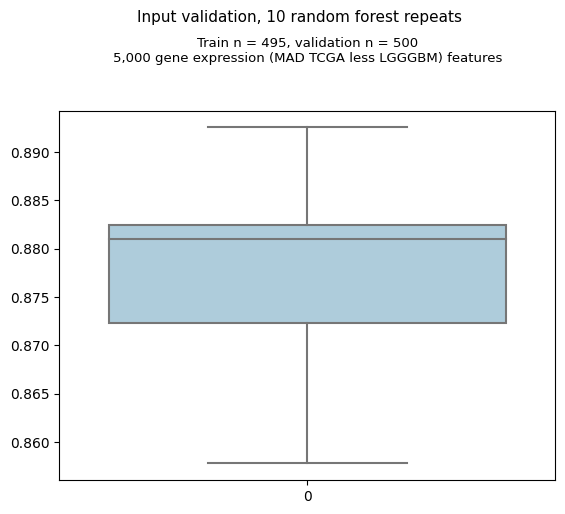

In [122]:
ax = sns.boxplot(inpt_val.iloc[9, :], # Most-updated average goes here
                 palette = [plt.cm.Paired(0)])
plt.suptitle('Input validation, '+str(repeats)+' random forest repeats',
             fontsize = 11, y = 1.09)
plt.title('Train n = '+str(
    len(val))+', validation n = '+str(
    len(trn))+'\n5,000 gene expression (MAD TCGA less LGGGBM) features',
          fontsize = 9.5, y = 1.11)

# add_stat_annotation(ax,
#                     data=input_val_frame,
#                     # x=x, y=y, order=order,
#                     box_pairs=[('Hold_in_raw_accuracy', 'Hold_out_raw_accuracy')],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=0)

plt.savefig(
    'i_o/'+v+'/input_val_'+str(trn_size)+'_'+val_split+'.png', bbox_inches = 'tight')

## VAE training

In [101]:
v

'rep_0.4'

2022-12-28 15:06:04.037585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 15:06:04.061787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 15:06:04.090999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 15:06:04.230269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 15:06:04.262344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 15:06:04.285994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-28 15:06:04.802518: I tensorflow/core/grappler/optimizers/cust

Train and decode with mad_5k_acros_no_LGGGBM feature set experiment done


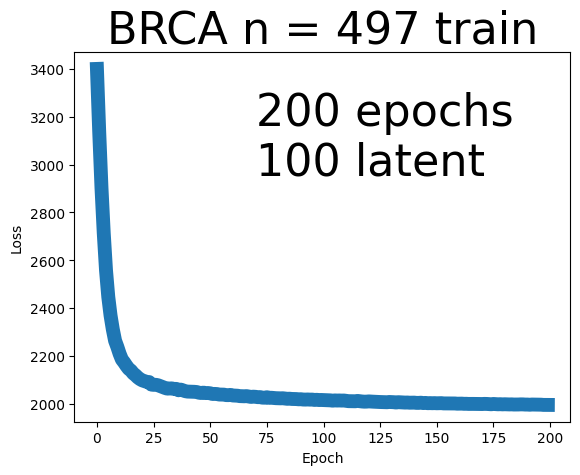

In [102]:
# Train and direct decode

train_object = trn   # <---- *** Do not train the VAE ever on hold-out; encode with pre-trained? - yes
fit_on_plot_title = train_object.index.name + ' n = ' + str(len(trn))
fit_on_file_write = train_object.index.name + '_n_'+ str(len(trn))

pre_trn = 'NONE'
feature_set = 'mad_5k_acros_no_LGGGBM'

pre_train_epochs = 'NA'
fine_tune_epochs = 'NA'

features = train_object.columns[1:]

original_dim = len(features)
feature_dim = len(features)
latent_dim = 100

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005
kappa = 1

beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

train_epochs = 200

fit_start = time.time()
history = vae.fit(train_object.iloc[:, 1:],
            epochs=train_epochs,
                  batch_size=50,
                  shuffle=True,
                  callbacks=[WarmUpCallback(beta, kappa)],
                  verbose=0
                  )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )

plt.savefig(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+
    feature_set+'_'+val_split+
    '.png', bbox_inches='tight')

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_object.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_object.iloc[:, 1:])),
                       index = train_object.index, columns = train_object.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_object.iloc[:, 1:]),
             index=train_object.index,
        )
latent_object.index.name = train_object.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_latent_object_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+val_split+
    '.tsv',
    sep = '\t')

print('Train and decode with '+feature_set+' feature set experiment done')

## VAE Pre train and fine-tune

2022-12-29 10:40:37.862437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-29 10:40:37.975785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-29 10:40:38.023172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-29 10:40:38.277037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-29 10:40:38.397069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-29 10:40:38.439055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-29 10:40:41.244005: I tensorflow/core/grappler/optimizers/cust

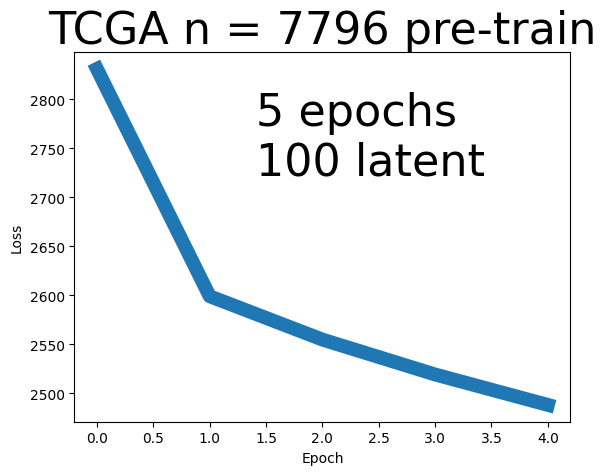

In [269]:
# Pre-train fitting with MAD 5k taken

train_file = pre_train_file
fit_on_plot_title = 'TCGA n = ' + str(len(pre_train_file))
fit_on_file_write = 'TCGA_n_'+ str(len(pre_train_file))
pre_trn = 'NONE'
feature_set = 'mad_5k_across'

fine_tune_epochs = 'NA'

features = train_file.columns[1:] # Now with pre-fit and fine-tune setup toggles

original_dim = len(features)
feature_dim = len(features)
latent_dim = 100               # Toggle here; to plot labels <--- Latent feature set diminsionality       *******

encoder_inputs = keras.Input(shape=(feature_dim,))
z_mean_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_1")(encoder_inputs)
z_mean_dense_batchnorm = layers.BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = layers.Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = layers.Dense(latent_dim, kernel_initializer='glorot_uniform', name="encoder_2")(encoder_inputs)
z_log_var_dense_batchnorm = layers.BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = layers.Activation('relu')(z_log_var_dense_batchnorm)

latent_space = layers.Lambda(compute_latent, output_shape=(latent_dim,), name="latent_space")([z_mean_encoded, z_log_var_encoded])

decoder_to_reconstruct = layers.Dense(feature_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
decoder_outputs = decoder_to_reconstruct(latent_space)

learning_rate = 0.0005
kappa = 1

beta = K.variable(0)

adam = optimizers.Adam(learning_rate=learning_rate)
vae_layer = CustomVariationalLayer()([encoder_inputs, decoder_outputs])
vae = Model(encoder_inputs, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta]) # Take-off point from pre-training to fine-tuning

pre_train_epochs = 5

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],  #  fit the VAE on object, toggled in the setup
            epochs=pre_train_epochs, batch_size=50, shuffle=True,
            callbacks=[WarmUpCallback(beta, kappa)],
                 verbose=0 #  <---------------------- turn this on for production *************
                 )
fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on_plot_title+' pre-train', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(pre_train_epochs)+' epochs'+
             '\n'+str(latent_dim)+' latent',
            xy = (.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )

# plt.legend(loc="lower left")
plt.savefig(
    'i_o/'+v+'/fit.'+fit_on_file_write+'.epochs.'+str(pre_train_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+fine_tune_epochs+
    '_latent_dim.'+str(latent_dim)+'_'+ # Do not change latent dim in the middle of transfer training
    # '_pltv-'+str(plt_v)+
    # 'fitting_epochs.'+str(epochs)+'_'+
    feature_set+'_'+v+
    '.png', bbox_inches='tight')

/Users/karlberb/miniforge3/envs/tf_M1_py3dot9/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-12-29 10:41:29.720317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-29 10:41:29.904846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fine tuning with mad_5k_across feature set experiment done


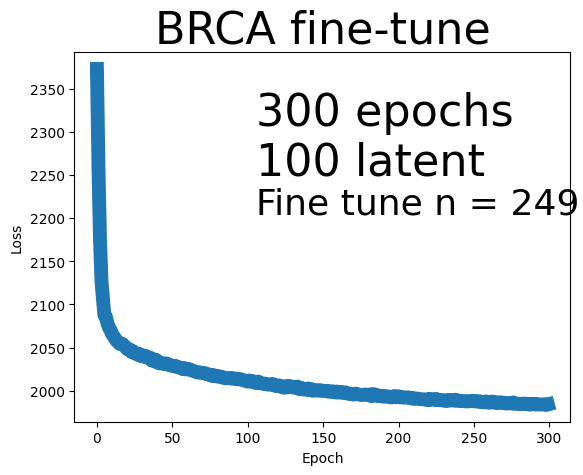

In [270]:
# Fine-tuning
# pretrain epochs variable in memory from above, latent dim also set already at this point

train_file = trn
pre_trn = fit_on_file_write
fit_on = trn.index.name

fine_tune_epochs = 300 # Overwrite 'NA' for this variable, from above; fine-tuning easy: 100, hard: 200

fit_start = time.time()
history = vae.fit(train_file.iloc[:, 1:],  #  fit the VAE on object, toggled in the setup
            epochs = fine_tune_epochs, batch_size=50, shuffle=True,
            callbacks = [WarmUpCallback(beta, kappa)],
                 verbose=0 #  <---------------------- turn this on for production *************
                 )

fit_end = time.time() - fit_start

plt.plot(history.history['loss'],label="loss",linewidth = 10)

plt.title(fit_on+' fine-tune', fontsize = 32
         )

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate(str(fine_tune_epochs)+' epochs'+
            '\n'+str(latent_dim)+' latent',       
            xy = (.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 32
            )
plt.annotate('Fine tune n = '+str(trn.shape[0]),             
            xy = (.4, .6), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize = 26
            )

# plt.legend(loc="lower left")
plt.savefig(
    'i_o/'+v+'/fit.'+fit_on+'.epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_latent_dim.'+str(latent_dim)+'_'+ # Do not change latent dim in the middle of transfer training
    # '_pltv-'+str(plt_v)+
    # 'fitting_epochs.'+str(epochs)+'_'+
    feature_set+'_'+v+
    '.png', bbox_inches='tight') # version 18, norm within cohort
# plt.close()

encoder = Model(encoder_inputs, z_mean_encoded)
decoder_input = keras.Input(shape = (latent_dim, ))
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

y_df = train_file.Labels

decoded = pd.DataFrame(decoder.predict(encoder.predict(train_file.iloc[:, 1:])),
                       index = train_file.index, columns = train_file.iloc[:, 1:].columns)

latent_object = pd.DataFrame(encoder.predict(train_file.iloc[:, 1:]),
             index=train_file.index,
                # columns=decode_df.iloc[:, 1:].columns # Columns are different because this is latent space
        )
latent_object.index.name = trn.index.name
latent_object = pd.concat( [pd.DataFrame(y_df), latent_object] , axis =1)
latent_object.to_csv(
    'i_o/'+v+'/fit.'+fit_on+'.epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_latent_object_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+v+
    '.tsv',
    sep = '\t')
# break
decoded_labeled = pd.concat( [pd.DataFrame(y_df), decoded] , axis =1)
decoded_labeled.to_csv(
    'i_o/'+v+'/fit.'+fit_on+'.epochs.'+str(fine_tune_epochs)+
    '_pre_trained_on.'+pre_trn+'.epochs.'+str(pre_train_epochs)+
    '_decoded_obj_latent_dim.'+str(latent_dim)+
    '_'+feature_set+'_'+v+
    '.tsv',
    sep = '\t')

print('Fine tuning with '+feature_set+' feature set experiment done')

## Latent plus input validation plot
Unskip now

In [ ]:
# Get the encoder
    # Held-out validation set must have same feature space to run a test on
    # This means a train-set trained encoder is required

In [ ]:
# Encoder in memory trained on trn set

In [271]:
val_encoded = pd.DataFrame(encoder.predict( # its ok the sample count does not match here, this is the whole point
    val.iloc[:, 1:]),
        index = val.index)
val_encoded_labeled = pd.concat(
    [pd.DataFrame(val.Labels),
     val_encoded] , axis =1)

In [272]:
val_encoded_labeled.shape # predict on with random forest

(746, 101)

In [273]:
# Latent vs. input
print('Latent validation start')
X_trn = latent_object.iloc[:, 1:]
y_trn = latent_object.iloc[:, 0]
X_val = val_encoded_labeled.iloc[:, 1:]
y_val = val_encoded_labeled.iloc[:, 0] 
val_lat_raw_acc_lst = []
val_lat_running_average = []
for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('five done')   
    
    clf_trn = RandomForestClassifier() # Leave in loop to reinitialie each time through
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_lat_raw_acc_lst.append(val_raw_acc) # Box plots
    val_lat_running_average.append(mean(val_lat_raw_acc_lst))
lat_val.insert(0, val_split, val_lat_running_average)
print('Latent validation complete')

Latent validation start
five done
Latent validation complete


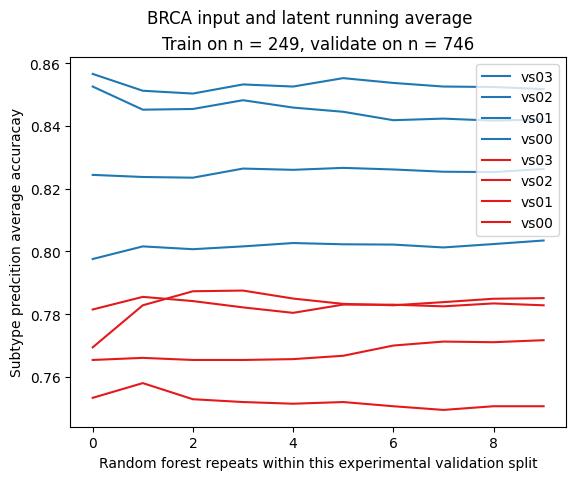

In [274]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run) 
plt.suptitle(fine_tune_file.index.name + ' input and latent running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+str(fine_tune_file.index.name)+'input_latent_running_average_repeats_'+str(
    repeats)+'_'+val_split+'_repeats'+pretrain_status+'.png', bbox_inches = 'tight')

## Decoded plus latent and input validation plot

### Decoded read
Skip

In [28]:
dec_pths = sorted(glob.glob('i_o/'+v+'/fit.BRCA*decoded*'+val_split+'.tsv'))
for pth in dec_pths:
    print(pth)

i_o/rep_0.2/fit.BRCA_n_500.epochs.100_pre_trained_on.NONE.epochs.NA_decoded_obj_latent_dim.100_mad_5k_acros_no_LGGGBM_vs05.tsv


In [29]:
trn_dec = pd.read_csv(dec_pths[0], sep = '\t', index_col = 0)

In [83]:
# Take trained encoder and decoder
val_decoded = pd.DataFrame(decoder.predict(encoder.predict(val.iloc[:, 1:])),
                       index = val.index, columns = val.iloc[:, 1:].columns)
val_decoded = pd.concat([val.iloc[:, 0], val_decoded], axis = 1)

In [30]:
trn_dec.shape

(500, 5001)

In [31]:
trn_dec.head(1)

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A09X,BRCA_4,0.003137,0.013563,0.061969,0.092185,0.007884,0.004684,0.003019,0.037026,0.013034,...,0.232048,0.22575,0.228447,0.29598,0.176973,0.306326,0.058374,0.112701,0.204532,0.059944


In [49]:
trn.shape

(500, 5001)

In [64]:
decoded.shape

(500, 5000)

In [63]:
decoded.head()

,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,N:GEXP::COL3A1:1281:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-A7-A13D,0.002353,0.018010,0.062597,0.117161,0.017180,0.014154,0.005973,0.017555,0.010403,0.058465,...,0.191479,0.299758,0.266679,0.259236,0.198943,0.173241,0.052870,0.247713,0.220081,0.034433
TCGA-GM-A3XL,0.004964,0.021274,0.021269,0.018225,0.032881,0.018695,0.005968,0.052340,0.015641,0.014670,...,0.206485,0.247038,0.221629,0.317675,0.129157,0.198371,0.102481,0.209865,0.270690,0.044581
TCGA-BH-A0HK,0.005326,0.017052,0.046896,0.031595,0.007599,0.006162,0.002974,0.027671,0.037927,0.047696,...,0.186005,0.271280,0.245825,0.234924,0.194128,0.305991,0.123260,0.133700,0.216746,0.186961
TCGA-OL-A5RZ,0.002251,0.006327,0.034850,0.019941,0.005286,0.003774,0.001554,0.018486,0.009993,0.022525,...,0.193584,0.141123,0.170473,0.146038,0.136338,0.126107,0.107549,0.177831,0.260399,0.026152
TCGA-E9-A2JT,0.002698,0.011741,0.051762,0.024436,0.007585,0.003085,0.001496,0.111770,0.007221,0.056780,...,0.106994,0.554489,0.196509,0.260815,0.239161,0.133773,0.116186,0.093351,0.143952,0.126408


In [65]:
trn.head()

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALI,BRCA_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALJ,BRCA_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-4H-AAAK,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-5L-AAT0,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
val = fine_tune_file.loc[fine_tune_file[~fine_tune_file.index.isin(trn.index)].index, :]

In [32]:
val.shape

(495, 5001)

In [59]:
val.iloc[:, 0]

BRCA
TCGA-3C-AAAU    BRCA_1
TCGA-3C-AALI    BRCA_4
TCGA-3C-AALJ    BRCA_2
TCGA-4H-AAAK    BRCA_1
TCGA-5L-AAT0    BRCA_1
                 ...  
TCGA-WT-AB44    BRCA_1
TCGA-XX-A899    BRCA_1
TCGA-XX-A89A    BRCA_1
TCGA-Z7-A8R5    BRCA_1
TCGA-Z7-A8R6    BRCA_2
Name: Labels, Length: 495, dtype: object

In [58]:
trn.head(1)

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
pd.concat([trn.iloc[:, 0], decoded], axis = 1)

,Labels,N:GEXP::ALB:213:,N:GEXP::TG:7038:,N:GEXP::COL1A1:1277:,N:GEXP::FN1:2335:,N:GEXP::KRT5:3852:,N:GEXP::KRT14:3861:,N:GEXP::KRT6A:3853:,N:GEXP::ADAM6:8755:,N:GEXP::SERPINA1:5265:,...,N:GEXP::C14orf1:11161:,N:GEXP::SMCHD1:23347:,N:GEXP::ARL2BP:23568:,N:GEXP::PITPNB:23760:,N:GEXP::KDM5A:5927:,N:GEXP::CNIH:10175:,N:GEXP::ACADS:35:,N:GEXP::YIPF2:78992:,N:GEXP::MEPCE:56257:,N:GEXP::PPARG:5468:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALI,BRCA_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-3C-AALJ,BRCA_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-4H-AAAK,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-5L-AAT0,BRCA_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A5QP,NaN,0.005507,0.009834,0.083893,0.048489,0.008462,0.006432,0.003073,0.019792,0.017247,...,0.174312,0.171335,0.246070,0.178212,0.124749,0.196892,0.164214,0.162688,0.218777,0.095723
TCGA-BH-A0B4,NaN,0.005402,0.009590,0.109960,0.096573,0.004391,0.003667,0.002310,0.023308,0.008739,...,0.191087,0.169245,0.297067,0.192404,0.112897,0.249510,0.099726,0.130614,0.163762,0.064491
TCGA-GM-A2DA,NaN,0.004025,0.011523,0.108560,0.056969,0.006805,0.004726,0.002945,0.054792,0.015296,...,0.190215,0.246854,0.230126,0.185327,0.127035,0.189461,0.126024,0.113680,0.208588,0.107066


### Decoded_labled object in memory

In [46]:
decoded_labeled

,Labels,N:GEXP::COL1A1:1277:,N:GEXP::TG:7038:,N:GEXP::FN1:2335:,N:GEXP::SERPINA1:5265:,N:GEXP::COL3A1:1281:,N:GEXP::COL1A2:1278:,N:GEXP::FTL:2512:,N:GEXP::GAPDH:2597:,N:GEXP::ACTB:60:,...,N:GEXP::DECR2:26063:,N:GEXP::ATPAF1:64756:,N:GEXP::TSPAN17:26262:,N:GEXP::TMEM50B:757:,N:GEXP::TMEM125:128218:,N:GEXP::NMD3:51068:,N:GEXP::HS2ST1:9653:,N:GEXP::CDH13:1012:,N:GEXP::C8orf30A:51236:,N:GEXP::SLC41A3:54946:
LGGGBM,,,,,,,,,,,,,,,,,,,,,
TCGA-DH-5142,LGGGBM_1,0.358366,0.335115,0.534209,0.623084,0.558256,0.465038,0.619486,0.637116,0.710901,...,0.554654,0.545949,0.577702,0.517181,0.308283,0.663511,0.666984,0.629250,0.550530,0.595899
TCGA-DU-7301,LGGGBM_1,0.441357,0.430990,0.548615,0.518498,0.559126,0.512470,0.567389,0.596366,0.631904,...,0.481043,0.592978,0.523652,0.495402,0.336510,0.681104,0.638427,0.582091,0.539872,0.553859
TCGA-HT-7485,LGGGBM_1,0.081438,0.533210,0.420864,0.329069,0.282969,0.291914,0.531954,0.578778,0.592415,...,0.494842,0.669434,0.545449,0.510955,0.592667,0.688424,0.653251,0.631404,0.528137,0.625104
TCGA-DU-A5TR,LGGGBM_1,0.486338,0.380586,0.581781,0.599807,0.546615,0.498889,0.657340,0.673654,0.747515,...,0.599837,0.576224,0.572018,0.521873,0.428366,0.565812,0.618517,0.540158,0.587290,0.625599
TCGA-HT-8107,LGGGBM_6,0.161592,0.558380,0.483545,0.205699,0.288422,0.337566,0.537562,0.648998,0.649446,...,0.565294,0.719048,0.597138,0.544889,0.637744,0.552749,0.617782,0.737791,0.515700,0.727850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-DH-A66F,LGGGBM_3,0.207758,0.446067,0.459099,0.257427,0.379229,0.395629,0.489181,0.589192,0.566143,...,0.563755,0.519374,0.506423,0.517095,0.435616,0.597310,0.484922,0.545964,0.568725,0.554718
TCGA-76-6664,LGGGBM_2,0.632213,0.289442,0.728233,0.597893,0.660321,0.658101,0.671662,0.764695,0.811926,...,0.637043,0.611132,0.596138,0.575262,0.252355,0.652705,0.740120,0.515660,0.643947,0.671366
TCGA-DU-7011,LGGGBM_1,0.406835,0.446365,0.560697,0.488278,0.543706,0.534827,0.578013,0.607064,0.653287,...,0.497770,0.605008,0.555112,0.499884,0.464552,0.630508,0.651795,0.629221,0.527658,0.608490


In [275]:
# Validate with train on decoded
print('Decoded validation start')
X_trn = decoded_labeled.iloc[:, 1:]
y_trn = decoded_labeled.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]   

val_dec_raw_acc_lst = []
val_dec_running_average = []

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('half done') 
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    val_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    val_dec_raw_acc_lst.append(val_raw_acc) # Box plots
    val_dec_running_average.append(mean(val_dec_raw_acc_lst))
dec_val.insert(0, val_split, val_dec_running_average)
print('Decoded validation complete')

Decoded validation start
half done
Decoded validation complete


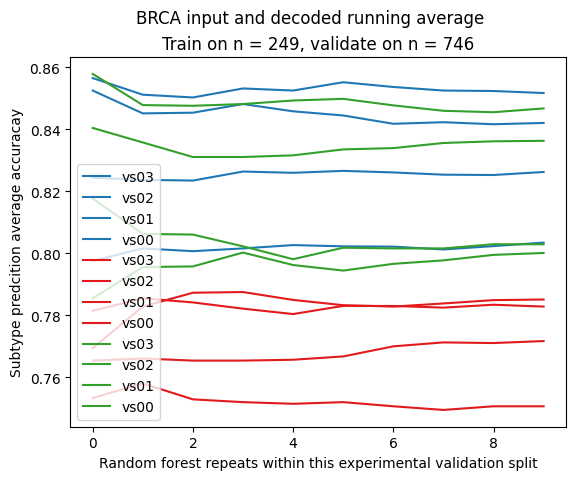

In [276]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)    
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
plt.suptitle(fine_tune_file.index.name + ' input and decoded running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+str(fine_tune_file.index.name)+'input_and_decoded_running_average_repeats_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')

In [ ]:
# auto jitter with y value subtraction (?)

# Synth main
Sythesize on latent and send to decoder  
Then train-on this synth lat set and finally predict validation set that has not gone to VAE at all.

In [35]:
latent_object

,Labels,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-D8-A147,BRCA_3,0.000000,0.000000,1.815639,0.517708,0.000000,0.000000,1.448425,2.136686,0.000000,...,1.445191,3.157501,0.000000,0.811743,0.534753,0.000000,0.0,0.000000,0.000000,0.000000
TCGA-EW-A1OY,BRCA_2,0.316403,0.846703,0.760631,1.216086,1.287744,0.000000,0.000000,0.994297,0.432688,...,0.000000,0.125847,0.000000,0.183635,0.000000,0.817755,0.0,0.000000,0.000000,0.650990
TCGA-AC-A2FB,BRCA_1,0.000000,0.744787,2.094962,0.000000,2.145458,0.293222,0.412760,0.000000,0.000000,...,0.062854,0.319504,0.000000,0.000000,0.000000,0.000000,0.0,1.175535,1.802405,0.000000
TCGA-C8-A138,BRCA_4,0.000000,0.663694,0.079000,1.942919,1.957429,0.000000,0.609117,0.000000,0.538705,...,0.044737,0.172088,2.133078,0.000000,1.110351,0.740820,0.0,1.379003,0.000000,0.000000
TCGA-AQ-A7U7,BRCA_1,0.000000,0.000000,0.962556,0.000000,0.856644,0.408856,2.278397,0.000000,0.000000,...,0.000000,0.993554,0.000000,0.000000,0.733198,0.652688,0.0,1.973720,0.832491,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E9-A5UO,BRCA_2,0.315839,0.000000,0.000000,0.000000,0.000000,0.990265,1.271938,0.000000,2.201978,...,0.000000,0.037450,1.993925,2.653132,0.000000,2.608500,0.0,0.000000,1.357840,1.703002
TCGA-E2-A14O,BRCA_2,1.240623,0.000000,0.000000,2.672950,1.631662,2.497270,0.000000,0.217711,2.197305,...,0.000000,0.145645,0.000000,0.000000,0.710459,0.000000,0.0,0.000000,0.000000,1.195948
TCGA-A8-A07Z,BRCA_1,2.050244,2.523755,1.105880,2.499879,0.000000,3.924040,0.000000,0.710182,1.972838,...,0.000000,0.285905,1.182834,0.000000,0.000000,0.000000,0.0,0.770347,2.044458,1.267381


In [277]:
synth_ndx_strt = 0
up_or_down = [1, -1]
# synth_full_frame10 = pd.DataFrame()
synth_full_frame = pd.DataFrame()
for subtype in sorted(latent_object.Labels.unique()): # Subset the latent feature frame on each subtype   
    print(subtype)
    sub = latent_object[latent_object.Labels == subtype] # Subset latent object by subtype
    synth_lat_feat_vec = [] # Blank list for synthetic latent feature vector
    # sub_len = len(sub)
    synth_sub_len = len(sub)*1  # <------ Toggle the integer at the end of this line to amplify the sample size
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    synth_sub_frame = pd.DataFrame(index = synth_index)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    sub_dict = {}
    for lat_feat in sub.columns[1:]:    # Go through the subtype latent feature set,
        lat_col = sub.loc[:, lat_feat] # Pull the feature column

        rand_lat_feat_vals = lat_col.sample( # Build a base synthetic feature vector
            synth_sub_len, replace = True)
        new_vals = []
        for feat_val in rand_lat_feat_vals:
            new_val = feat_val+rand_lat_feat_vals.mean()*.05*sample(up_or_down,1)[0]
            if new_val < 0:
                new_val = 0
            new_vals.append(new_val) # Fuzz
        sub_dict[lat_feat] = new_vals
    synth_sub_frame = pd.DataFrame(sub_dict)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])    
    synth_full_frame = pd.concat(
        [synth_full_frame, synth_sub_frame], axis = 0)
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
synth_full_frame.columns = latent_object.columns

BRCA_1
BRCA_2
BRCA_3
BRCA_4


In [179]:
synth_full_frame.shape

(249, 101)

In [180]:
trn.Labels.value_counts()

BRCA_1    122
BRCA_3     56
BRCA_2     53
BRCA_4     18
Name: Labels, dtype: int64

In [181]:
synth_full_frame.Labels.value_counts()

BRCA_1    122
BRCA_3     56
BRCA_2     53
BRCA_4     18
Name: Labels, dtype: int64

In [182]:
val.Labels.value_counts()

BRCA_1    413
BRCA_2    152
BRCA_3    119
BRCA_4     62
Name: Labels, dtype: int64

In [37]:
synth_full_frame.head(1)

,Labels,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,BRCA_1,0.618931,0.744102,1.420737,1.35201,1.524167,0.680241,0.026584,0.342948,1.767672,...,0.011131,0.042004,0.035522,0.019733,0.020533,0.573589,1.396999,0.607937,0.0,0.024069


In [ ]:
### Decode synthetic generated from latent

In [278]:
synth_lat_dec = pd.concat([synth_full_frame.iloc[:, 0],
                       pd.DataFrame(decoder.predict(synth_full_frame.iloc[:, 1:]), index = synth_full_frame.index)],
                     axis = 1)
synth_lat_dec.columns = trn.columns

In [184]:
synth_lat_dec.shape

(249, 5001)

In [44]:
synth_lat_dec.head(1)

,Labels,N:GEXP::COL1A1:1277:,N:GEXP::TG:7038:,N:GEXP::FN1:2335:,N:GEXP::SERPINA1:5265:,N:GEXP::COL3A1:1281:,N:GEXP::COL1A2:1278:,N:GEXP::FTL:2512:,N:GEXP::GAPDH:2597:,N:GEXP::ACTB:60:,...,N:GEXP::DECR2:26063:,N:GEXP::ATPAF1:64756:,N:GEXP::TSPAN17:26262:,N:GEXP::TMEM50B:757:,N:GEXP::TMEM125:128218:,N:GEXP::NMD3:51068:,N:GEXP::HS2ST1:9653:,N:GEXP::CDH13:1012:,N:GEXP::C8orf30A:51236:,N:GEXP::SLC41A3:54946:
0,BRCA_1,0.044816,0.006466,0.058121,0.028504,0.062301,0.037549,0.050556,0.131991,0.265079,...,0.20338,0.282729,0.136756,0.180428,0.279563,0.149174,0.157563,0.156905,0.072092,0.184834


In [279]:
# Validate synthetic: train on synthetic latent decoded, predict on validation

print('Synth latent validation start')
X_trn = synth_lat_dec.iloc[:, 1:]
y_trn = synth_lat_dec.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]   

synth_lat_raw_acc_lst = []
synth_lat_running_average = []

for r in list(range(0, repeats)): # pre-set, to be re-used for all take-off points
    if r == 5:
        print('half')
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    synth_lat_raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    synth_lat_raw_acc_lst.append(synth_lat_raw_acc) # Box plots
    synth_lat_running_average.append(mean(synth_lat_raw_acc_lst))
synth_lat_val.insert(0, val_split, synth_lat_running_average)
print('Synth latent complete')

Synth latent validation start
half
Synth latent complete


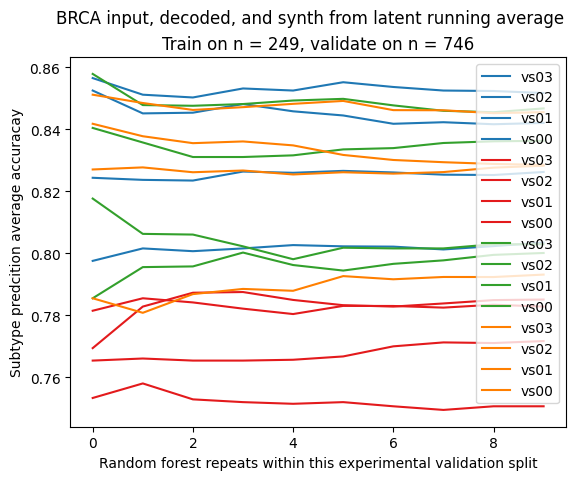

In [280]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)    
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = plt.cm.Paired(7), label = run)
plt.suptitle(fine_tune_file.index.name + ' input, decoded, and synth from latent running average')
plt.title('Train on n = '+str(
    len(trn))+', validate on n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
plt.legend()
plt.savefig('i_o/'+v+'/'+str(fine_tune_file.index.name)+'input_latent_decoded_synthLat_running_average_repeats_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')

## Synthetic input

In [281]:
synth_ndx_strt = 0 # index range var
up_or_down = [1, -1] # Fuzz up or down

# synth_full_frame10 = pd.DataFrame()

synth_input_full_frame = pd.DataFrame()

for subtype in sorted(trn.Labels.unique()): # Subset the latent feature frame on each subtype
    print(subtype)
    sub = trn[trn.Labels == subtype]
    synth_lat_feat_vec = []          # Latent feature notation wrong in this application to input data
    synth_sub_len = len(sub)*1  # <------ Toggle the integer at the end of this line to amplify the sample size
    
    synth_index = ['SYNTH-' + fine_tune_file.index.name + '-' + jtem for jtem in [str(
        item).zfill(5) for item in list(range(synth_ndx_strt,
                                              synth_sub_len + synth_ndx_strt))]]
    sub_dict = {}
    for lat_feat in sub.columns[1:]:               # Go through the subtype latent feature set,
        lat_col = sub.loc[:, lat_feat]

        rand_lat_feat_vals = lat_col.sample(
            synth_sub_len, replace = True)
        new_vals = []
        for input_feature_value in rand_lat_feat_vals:
            new_val = input_feature_value+rand_lat_feat_vals.mean()*.05*sample(up_or_down,1)[0]
            if new_val < 0:
                new_val = 0
            new_vals.append(new_val) # Fuzz
        sub_dict[lat_feat] = new_vals
    synth_sub_frame = pd.DataFrame(sub_dict)
    synth_sub_frame.insert(0, 'Labels', sub.Labels[0])
    
    synth_input_full_frame = pd.concat(
        [synth_input_full_frame, synth_sub_frame], axis = 0)
    
    synth_ndx_strt = synth_ndx_strt + synth_sub_len
print('Synth input done')

BRCA_1
BRCA_2
BRCA_3
BRCA_4
Synth input done


In [282]:
(synth_input_full_frame.iloc[:, 1:] < 0).sum().sum()

0

In [ ]:
# Replicates .04 - run BRCA direct at 200 epochs then with pre-training
# Remove dataframe concatenations from input synthesis - done
# check negative synthetic expression assigment - done
    # Fix negative synthetic expression assigment for the latent method - done
# Run a summary box star plot - 

# Do some TCGA pre-training - 
    # return to BRCA for pre-training comparison - inprocess

# Run a learning curve for every replicate
# Put lines on the learning curves

# HNSC and LUAD are 4th and 5th largest

In [188]:
synth_input_full_frame.shape

(249, 5001)

In [ ]:
# Remove labels, encode and decode with trained VAE, reinstall labels

In [283]:
synth_input_decoded = pd.DataFrame(decoder.predict(encoder.predict(synth_input_full_frame.iloc[:, 1:])),
                       index = synth_input_full_frame.index, columns = synth_input_full_frame.iloc[:, 1:].columns)
synth_input_decoded = pd.concat([synth_input_full_frame.iloc[:, 0], synth_input_decoded], axis = 1)
synth_input_decoded.columns = fine_tune_file.columns

In [284]:
# Synth input val

print('Start synth latent accuracy')
synth_input_raw_acc_lst = []
synth_input_running_average = []
X_trn = synth_input_decoded.iloc[:, 1:]
y_trn = synth_input_decoded.iloc[:, 0]
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0] 

for r in list(range(0, repeats)):
    if r == 5:
        print('5 repeats complete')   
    
    clf_trn = RandomForestClassifier()
    clf_trn.fit(X_trn, y_trn)
    raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))
    
    synth_input_raw_acc_lst.append(raw_acc)
    synth_input_running_average.append(mean(synth_input_raw_acc_lst))
synth_inpt_val.insert(0, val_split, synth_input_running_average)
print('Input synth validation complete')

Start synth latent accuracy
5 repeats complete
Input synth validation complete


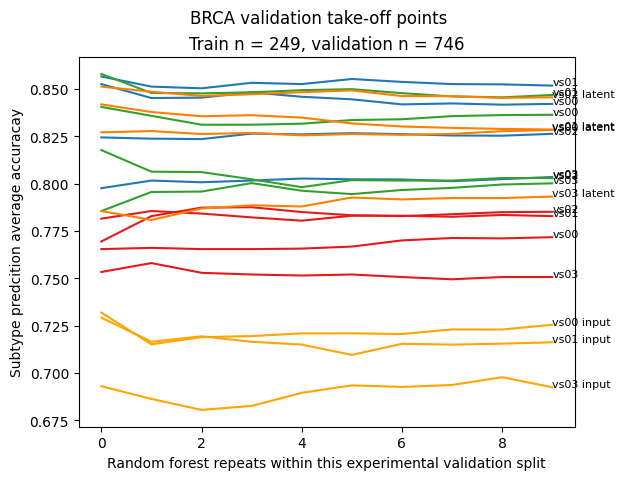

In [285]:
for run in inpt_val.columns:
    plt.plot(inpt_val[run], color = plt.cm.Paired(1), label = run)
    plt.annotate(run, (9, inpt_val[run][9]),
                  fontsize = 8,
                  # ha = 'center'
                 )
for run in lat_val.columns:
    plt.plot(lat_val[run], color = plt.cm.Paired(5), label = run)
    plt.annotate(run, (9, lat_val[run][9]), fontsize = 8)    
for run in dec_val.columns:
    plt.plot(dec_val[run], color = plt.cm.Paired(3), label = run)
    plt.annotate(run, (9, dec_val[run][9]), fontsize = 8)
for run in synth_lat_val.columns:
    plt.plot(synth_lat_val[run], color = plt.cm.Paired(7), label = run)
    plt.annotate(run+' latent', (9, synth_lat_val[run][9]), fontsize = 8)
for run in synth_inpt_val.columns:
    plt.plot(synth_inpt_val[run], color = 'orange', label = run)    
    plt.annotate(run+' input', (9, synth_inpt_val[run][9]), fontsize = 8)
plt.suptitle(fine_tune_file.index.name + ' validation take-off points')
plt.title('Train n = '+str(
    len(trn))+', validation n = '+str(
    len(val)))
plt.ylabel('Subtype predcition average accuracay')
plt.xlabel('Random forest repeats within this experimental validation split')
# plt.legend()
plt.savefig('i_o/'+v+'/'+str(fine_tune_file.index.name)+'input_decoded_synthLat_synthInpt_running_average_repeats_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')

## L. curve

In [ ]:
# When building a learning curve, predict on entire validation - current
# or subset of validation frame (?)

In [192]:
resmpl_count = 10 # number of times to repeat random sampling at each sample step size

In [193]:
df_to_clf = trn
d_phs = 'input'

In [196]:
df_to_clf = decoded_labeled
d_phs = 'decoded'

In [199]:
df_to_clf = synth_lat_dec
d_phs = 'lat_synth'

In [208]:
df_to_clf = synth_input_decoded
d_phs = 'inpt_synth'

In [209]:
# Produce box_curve_frame
accuracy_curve_frame = pd.DataFrame()
X_val = val.iloc[:, 1:]
y_val = val.iloc[:, 0]
for smp_sz in list(range(10, 151, 10)):
    step_frame = pd.DataFrame()
    print(smp_sz)

    RF_output = []
    for r in list(range(0, resmpl_count)):
        
        labeled_sample_subset_frame = df_to_clf.sample(smp_sz) # df_to_clf set as decoded object now, not the input
        X_trn = labeled_sample_subset_frame.iloc[:, 1:]
        y_trn = labeled_sample_subset_frame.iloc[:, 0]

        clf_trn = RandomForestClassifier()
        clf_trn.fit(X_trn, y_trn)
        
        raw_acc = accuracy_score(y_val, clf_trn.predict(X_val))

        RF_output.append(raw_acc)
    
    step_frame['data_phase'] = [d_phs] * resmpl_count
    
    step_frame['step_size'] = [smp_sz] * resmpl_count
    step_frame['Accuracy'] = RF_output
    accuracy_curve_frame = pd.concat( [accuracy_curve_frame, step_frame] , axis = 0)    
    
print('box curve frame n done')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
box curve frame n done


In [195]:
input_bx_crv = accuracy_curve_frame
# input_bx_crv

In [198]:
decoded_bx_crv = accuracy_curve_frame

In [201]:
lat_synth_bx_crv = accuracy_curve_frame

In [210]:
inpt_synth_bx_crv = accuracy_curve_frame

In [211]:
box_curve_frame = pd.concat(
    [input_bx_crv,
     decoded_bx_crv,
     lat_synth_bx_crv,
     inpt_synth_bx_crv] , axis = 0)

In [212]:
box_curve_frame.data_phase.unique()

array(['input', 'decoded', 'lat_synth', 'inpt_synth'], dtype=object)

In [213]:
box_curve_frame

,data_phase,step_size,Accuracy
0,input,10,0.709115
1,input,10,0.648794
2,input,10,0.599196
3,input,10,0.564343
4,input,10,0.626005
...,...,...,...
5,inpt_synth,150,0.699732
6,inpt_synth,150,0.664879
7,inpt_synth,150,0.659517
8,inpt_synth,150,0.687668


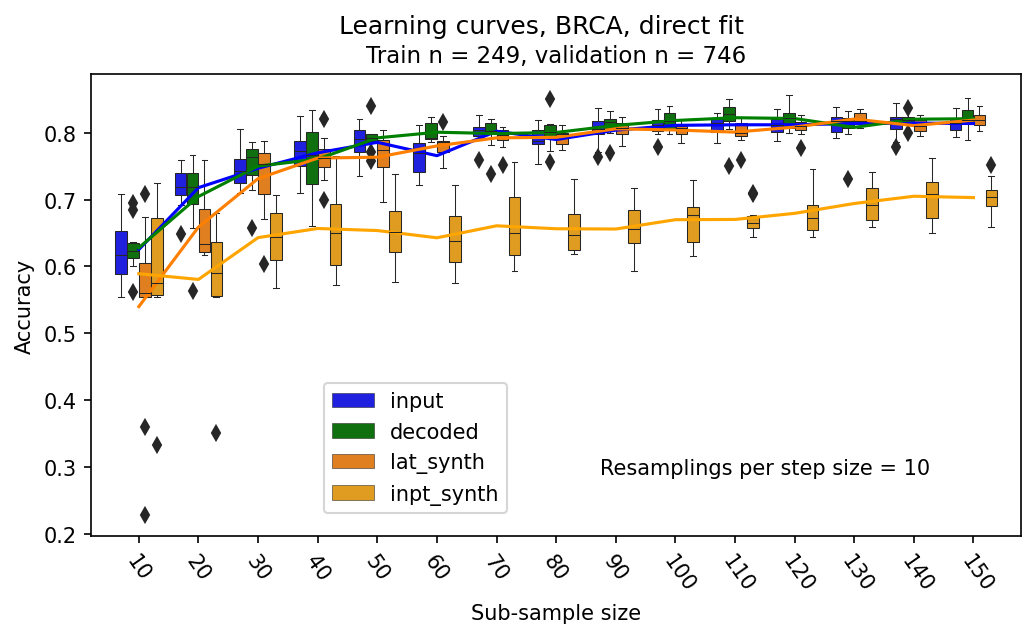

In [214]:
# Box curve, hue on data_phase column
figure(figsize=(8, 4), dpi=150)
palette=['blue','green', plt.cm.Paired(7), 'orange']
ax = sns.boxplot(x='step_size', y='Accuracy',
            hue='data_phase', palette=palette,
            data=box_curve_frame, linewidth = .5)
phase_list = ['input', 'decoded', 'lat_synth', 'inpt_synth']

for pal_idx, phase in enumerate(phase_list):
    mean_list = []
    for step_size in box_curve_frame.step_size.unique():
        phase_frame = box_curve_frame[box_curve_frame.data_phase == phase]
        mean_list.append(mean(phase_frame[phase_frame.step_size == step_size].Accuracy))
    plt.plot(mean_list, color = palette[pal_idx])
plt.suptitle('Learning curves, '+trn.index.name+', direct fit')
plt.title('Train n = '+str(len(trn))+', validation n = '+str(len(val)), fontsize = 11) # across or within cohorts
plt.ylabel('Accuracy')
plt.xlabel('Sub-sample size')
plt.annotate('Resamplings per step size = '+str(resmpl_count),
                xy=(.5, .3), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )
plt.legend(loc=(.25,.05))
ax.set_xticklabels(ax.get_xticklabels(),rotation=-55,
                   ha='left',
                   rotation_mode='anchor'
                  )
plt.savefig(
    'i_o/'+v+'/'+fine_tune_file.index.name+'_learning_curve_with_TCGA_pretrain_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')

In [ ]:
plt.annotate('Synthetic data ratio: 200%',
                xy=(.45, .35), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                )

## Front-end box

In [189]:
inpt_summ = pd.DataFrame(data = inpt_val.iloc[9,:])
inpt_summ.insert(0, 'Take-off_point', 'input')

In [190]:
dec_summ = pd.DataFrame(data = dec_val.iloc[9,:])
dec_summ.insert(0, 'Take-off_point', 'decoded')

In [191]:
syn_lat_summ = pd.DataFrame(data = synth_lat_val.iloc[9,:])
syn_lat_summ.insert(0, 'Take-off_point', 'latent_synth')

In [192]:
syn_inpt_summ = pd.DataFrame(data = synth_inpt_val.iloc[9,:])
syn_inpt_summ.insert(0, 'Take-off_point', 'input_synth')

In [193]:
summ = pd.concat([inpt_summ, dec_summ, syn_lat_summ, syn_inpt_summ])

In [194]:
summ

,Take-off_point,9
vs04,input,0.979496
vs03,input,0.969424
vs02,input,0.970504
vs01,input,0.959712
vs00,input,0.970144
vs04,decoded,0.976259
vs03,decoded,0.970504
vs02,decoded,0.973381
vs01,decoded,0.960072
vs00,decoded,0.967626


In [195]:
summ.columns = ['Take-off_point', 'Accuracy']

In [ ]:
# Plot the front-end model performance
# This is how to gauge the quality of the input to the learning curve

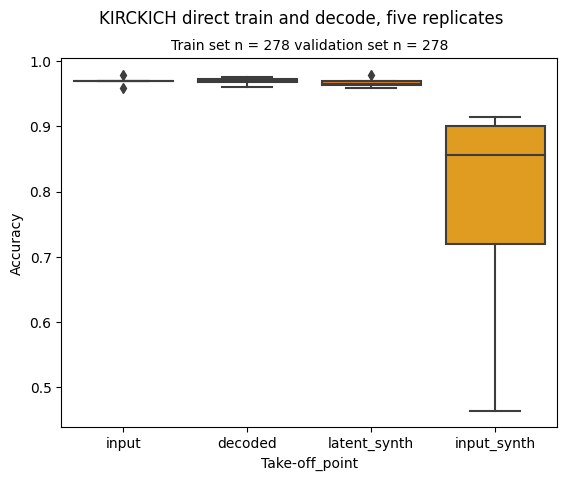

In [196]:
my_pal = {'input': plt.cm.Paired(1),
          'decoded': plt.cm.Paired(3),
          'latent_synth': plt.cm.Paired(7),
          'input_synth': 'orange'}

# figure(figsize=(8, 4), dpi=150)
ax = sns.boxplot(summ, x='Take-off_point', y='Accuracy',
           palette = my_pal)

# add_stat_annotation(ax,
#                     data=summ,
#                     x='Take-off_point',
#                     y='Accuracy',
#                     # order=order,
#                     box_pairs=[('input', 'decoded'),
#                               ('input', 'latent_synth'),
#                               ('input', 'input_synth')
#                               ],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=0)

plt.suptitle(trn.index.name+' direct train and decode, five replicates')
plt.title('Train set n = '+str(len(trn))+' validation set n = '+str(len(val)),
         fontsize = 10)
plt.savefig('i_o/'+v+'/'+trn.index.name+'_front_end_direct_'+str(
    repeats)+'_'+val_split+'_repeats.png', bbox_inches = 'tight')